In [124]:
import numpy as np
import pandas as pd 

import re

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import plotly.graph_objects as go


In [193]:
df = pd.read_csv('/home/enno/uni/SS24/thesis/01_data/hendecads/stretches_w_groups.csv').drop(columns=['Unnamed: 0'])
df['stretch_ix'] = df['stretch_ix'].apply(lambda x: list(map(int, x.strip('[]').split(','))))

df.head()

,id,seq,stretch_ix,stretch_seq,avg_cc,group_id
0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041,unassigned
1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364,unassigned
2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002,unassigned
3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689,group_42
4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424,group_38


In [194]:
groups = df['group_id'].unique()
group_dict = {group: i for i, group in enumerate(groups)}

df['group_ix'] = df['group_id'].apply(lambda x: group_dict[x])
df

,id,seq,stretch_ix,stretch_seq,avg_cc,group_id,group_ix
0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041,unassigned,0
1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364,unassigned,0
2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002,unassigned,0
3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689,group_42,1
4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424,group_38,2
...,...,...,...,...,...,...,...
40585,XP_034013580.1,MKLNWLLGILPIVAANFDDWSKADLTQFLEDRNVTVQKGDDLVQLA...,"[667, 798]",kdakksgesfaslasksgawyadafysvasesgesaasqalqtgqk...,0.000553,group_106,71
40586,GFR06050.1,MSDVYMDDLLTGADDLESGRKLQEQLVSLLRGAGMELHKWSASNPL...,"[578, 680]",eqrsiseeyekirdyfkdlkiklrekftrfgqwvkgkyergleksk...,0.000696,group_9,59
40587,KAG2190414.1,MSSSILRASIRRNATIANKRFYSAPPPPPYAPNNQGGGNGGLFLGL...,"[65, 170]",gtltkqgevvdqkiqegkqavrdkadeakakyeqskseagqavdqk...,0.000676,unassigned,0
40588,MBY0528383.1,MRVYCSLLASLLTCATIASQPPPLVFNGGTNSLAPRRILAAEKQET...,"[734, 833]",isaltndknrmvrknavdslgffpwdakaivpllvallsdkdsdla...,0.000714,group_1_1,5


## Dictionaries and Utils

In [195]:
aa_dict = {'r': '+',
           'h': '+',
           'k': '+',
           'd': '-',
           'e': '-',
           's': 'polar',
           't': 'polar',
           'n': 'polar',
           'q': 'polar',
           'c': 'special',
           'u': 'special',
           'g': 'special',
           'p': 'special',
           'a': 'hydrophobic',
           'v': 'hydrophobic',
           'i': 'hydrophobic',
           'l': 'hydrophobic',
           'm': 'hydrophobic',
           'f': 'hydrophobic',
           'y': 'hydrophobic',
           'w': 'hydrophobic',
           'x': 'padding'}

aa_num_dict = {'r': 0,
               'h': 0,
               'k': 0,
               'd': 1,
               'e': 1,
               's': 2,
               't': 2,
               'n': 2,
               'q': 2,
               'c': 3,
               'u': 3,
               'g': 3,
               'p': 3,
               'a': 4,
               'v': 4,
               'i': 4,
               'l': 4,
               'm': 4,
               'f': 4,
               'y': 4,
               'w': 4,
               'x': 5}

color_dict = {'+': '#00A012',           # green  
              '-': '#D81B60',           # red
              'polar': '#FFC107',       # yellow
              'hydrophobic': '#1E88E5', # blue    
              'special': '#ADADAD',     # grey
              'padding': '#FFFFFF'}     # white 

color_num_dict = {0: '#00A012',           # green
                  1: '#D81B60',           # red
                  2: '#FFC107',           # yellow
                  3: '#1E88E5',           # blue
                  4: '#ADADAD',           # grey
                  5: '#FFFFFF'}           # white

In [196]:
# Letter code and color code for expected hendecad repeat
repeat = ['A', '*', '*', 'D', 'E', '*', '*', 'H', '*', '*', '*']
color_repeat = [color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['hydrophobic'], color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['hydrophobic'], color_dict['special'], color_dict['special'], color_dict['special']]

## Visual

In [197]:
def plot_eleven_repeat(seq_id, seq, n_shift=0, save=False):
    seq = seq[n_shift:]
    
    n = len(seq)
    q = n // 11
    r = n % 11

    positions = [repeat[i%11] for i in range(len(seq))]
    colors = [color_dict[aa_dict[aa]] for aa in seq]
    
    # pad last hendecad with padding color
    if n % 11 != 0:
        positions += ['x'] * (11 - r)
        colors += [color_dict['padding']] * (11 - r)
    
    fig, axes = plt.subplots(q+1, 1, figsize=(6, q/3))

    first = True
    for ax in axes:
        
        if first:
            ax.set_title(seq_id) 
            first = False
        
        ax.bar(np.arange(11), np.ones(11), color=colors[:11], edgecolor='black')
        ax.set_yticks([])
        ax.set_xticks([])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
        colors = colors[11:]
        positions = positions[11:]

    ax.set_xticks(np.arange(11))
    ax.set_xticklabels(repeat)

    legend_elements = [Patch(facecolor=color_dict[aa], edgecolor='black', label=aa) for aa in color_dict.keys()]
    plt.legend(handles=legend_elements, loc='right', bbox_to_anchor=(1.33, q-2))
    
    if save:
        plt.savefig(f'/home/enno/uni/SS23/thesis/seq_analysis/plots/{seq_id}.png', bbox_inches='tight')
        plt.clf()
    else:
        plt.show()

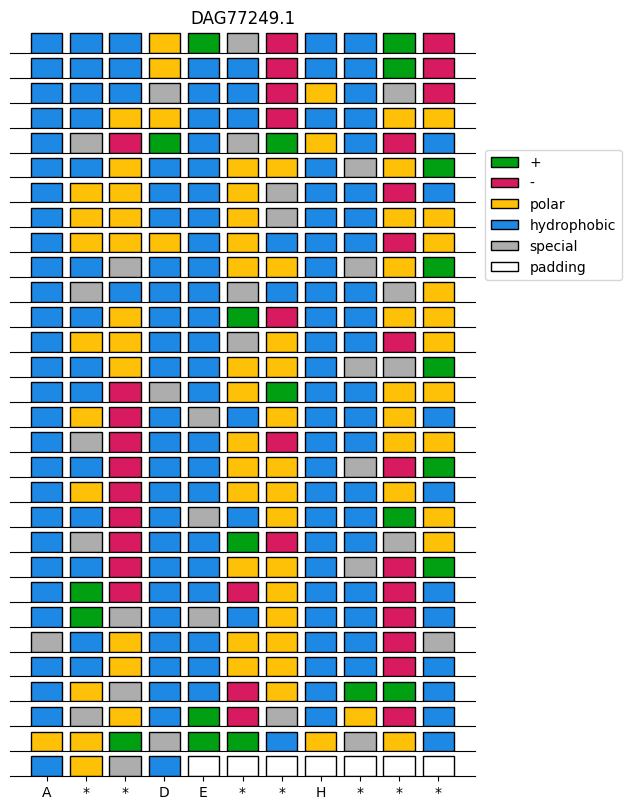

In [198]:
TMP = 'DAG77249.1'
MACH = 'WP_132310275.1'

plot_eleven_repeat(TMP, df[df['id'] == TMP]['stretch_seq'].values[0], n_shift=1)

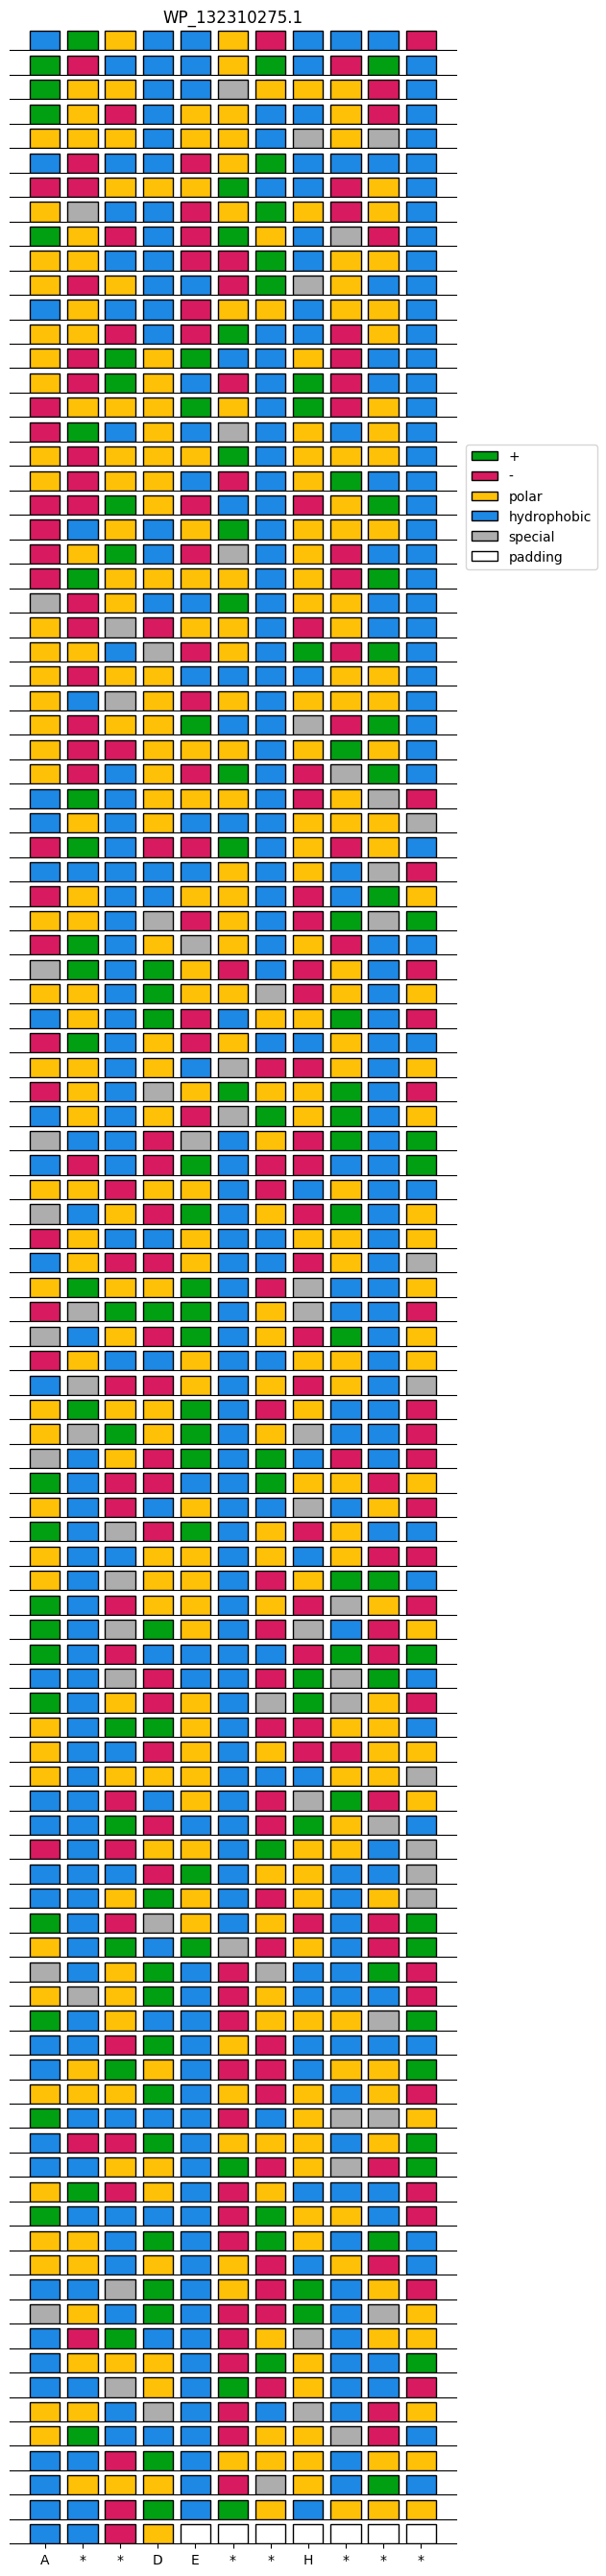

In [131]:
plot_eleven_repeat(MACH, df[df['id'] == MACH]['stretch_seq'].values[0])

## RegEx

In [379]:
def find_repeats(seq, pattern, i):
    # max_s1 is the maximum number of repeats in one reading frame
    # ! searches patterns in all reading frames
    
    pattern = re.compile(pattern)
    len_pattern = 11*i

    matches = pattern.findall(seq)
    matches_ix = [(m.start(1), m.end(1)) for m in pattern.finditer(seq)]
    
    max_n_repeats = sum([len(seq[l:]) // len_pattern for l in range(len_pattern)])
    match_ratio = len(matches) / max_n_repeats if max_n_repeats != 0 else 0

    return len(matches), matches_ix, match_ratio

In [380]:
pattern = r'[avilm].{2}[avilm].{3}[avilm].{3}' * 3
pattern = r'(?=(' + pattern + r'))'

test = 'kaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa'
find_repeats(test, pattern, 3)

(0, [], 0)

In [381]:
test = 'nnnnnnnnnnnnnnnnnnnn'
find_repeats(test, pattern, 1)

(0, [], 0.0)

In [359]:
pattern = r'[avilm].{2}[avilm].{3}[avilm].{3}' * 3

pattern = r'(?=(' + pattern + r'))'
pattern

'(?=([avilm].{2}[avilm].{3}[avilm].{3}[avilm].{2}[avilm].{3}[avilm].{3}[avilm].{2}[avilm].{3}[avilm].{3}))'

In [383]:
# 1  2  3  4  5  6  7  8  9 10 11
# a  b  c  d  e  f  g  h  i  j  k 

# pattern = r'[avilm].{6}[avilm].{3}' # detects a------h---

R = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 25, 50, 75, 100, 150, 168]


# loop to find increasing number of consecutive hendecad repeats
for n in R:
    
    pattern = r'[avilm].{2}[avilm].{3}[avilm].{3}' * n # detects a--d---h---

    pattern = r'(?=(' + pattern + r'))'


    len_pattern = 11 * n

    n_hits_out = []
    hit_ratio_out = [] 
    hits_ix_out = []

    for i in range(len(df)):
        n_hits, hits_ix, hit_ratio = find_repeats(df.loc[i, 'stretch_seq'], pattern, n)
        
        n_hits_out.append(n_hits)
        hits_ix_out.append(hits_ix)
        hit_ratio_out.append(hit_ratio)

    df[f'{n}R'] = n_hits_out
    df[f'{n}R_ratio'] = hit_ratio_out 
    df[f'{n}R_ix'] = hits_ix_out

In [387]:
df.to_csv('/home/enno/uni/SS24/thesis/01_data/hendecads/stretches_w_groups_w_repeats.csv')

In [174]:
# ribo_seq = df[df['49R'] > 0].iloc[-1] # https://www.ebi.ac.uk/pdbe/entry/pdb/6xyw/biology

### Histograms

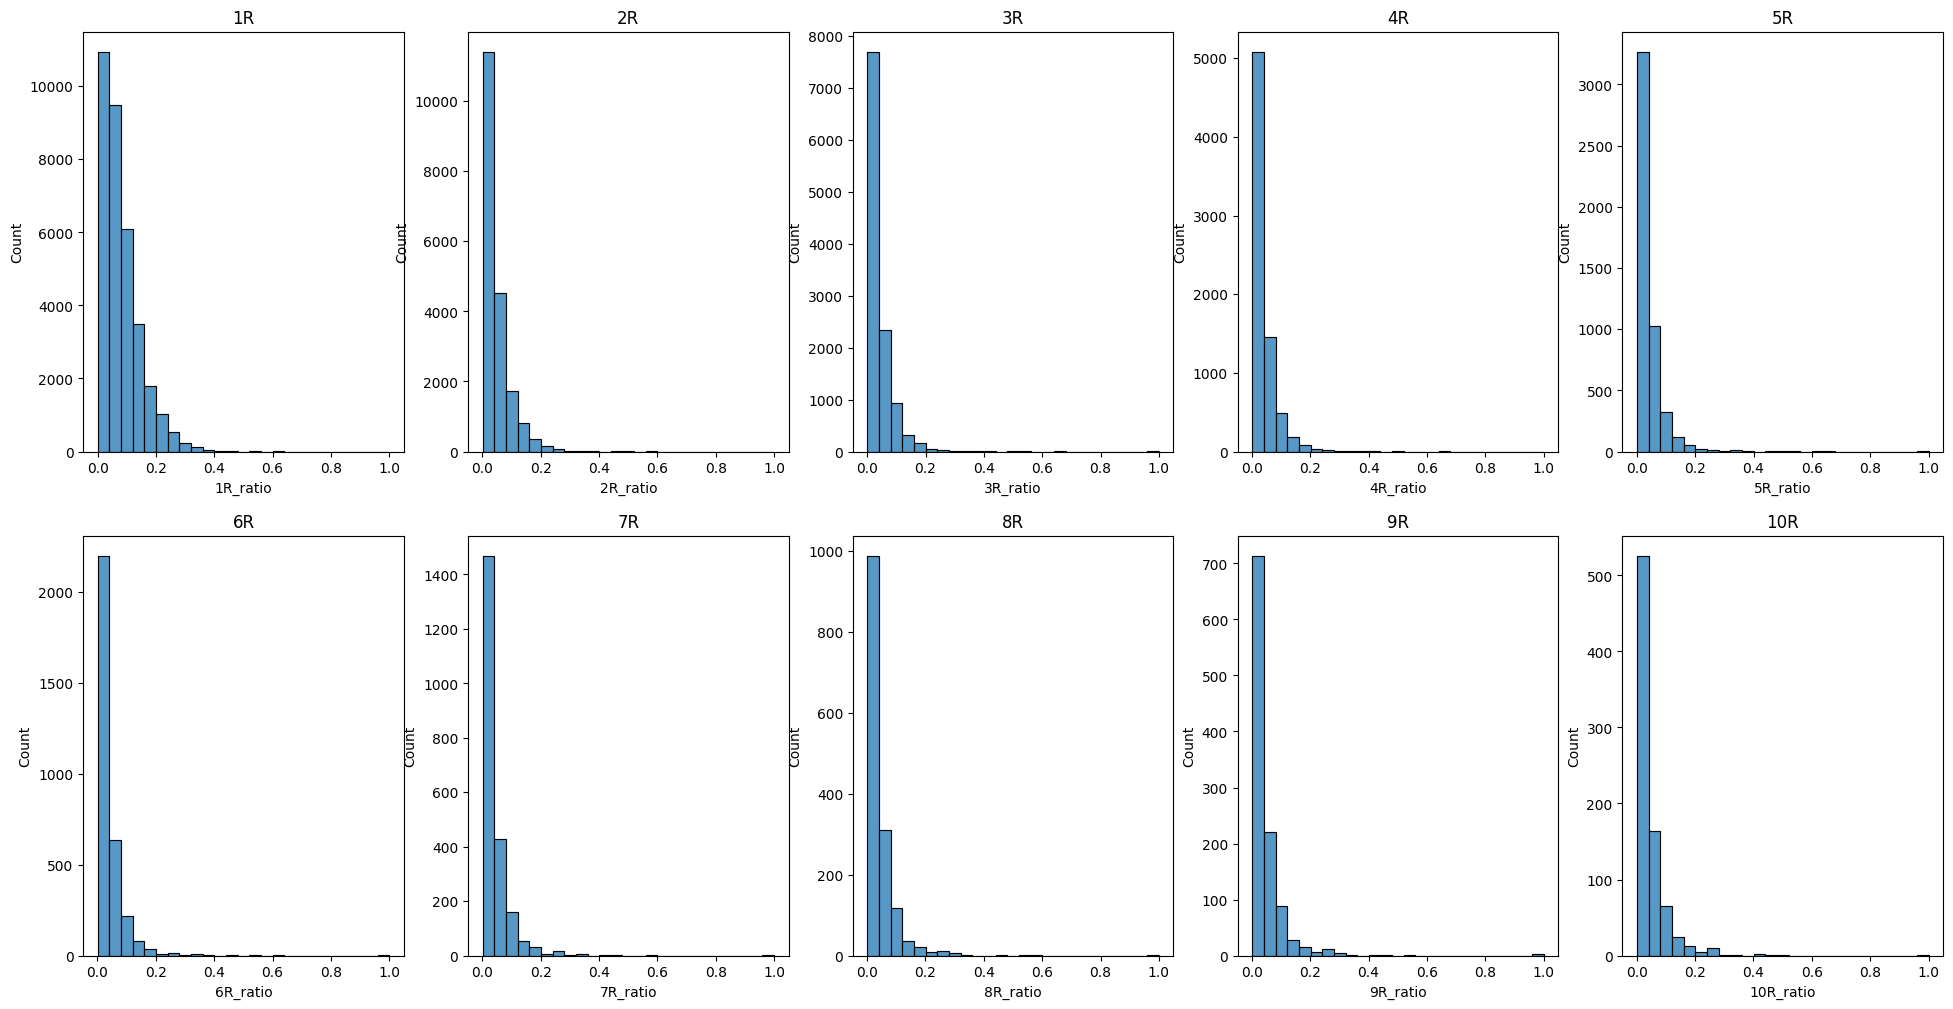

In [406]:
# Plot all xR ratios
fig, ax = plt.subplots(2, 5, figsize=(24, 12))

ix = 0
for i in range(2):
    for j in range(5):
        n = R[ix]
        ix += 1

        sns.histplot(df[df[f'{n}R_ratio'] > 0][f'{n}R_ratio'], bins=25, ax=ax[i, j])
        ax[i, j].set_title(f'{n}R')

In [407]:
df

,id,seq,stretch_ix,stretch_seq,avg_cc,group_id,group_ix,1R,2R,3R,...,7R_ratio,8R_ratio,9R_ratio,10R_ratio,25R_ratio,50R_ratio,75R_ratio,100R_ratio,150R_ratio,168R_ratio
0,MCD6041253.1,Mrlvyvavaailcsfsttslagaektakragkfvektatragkfve...,"[1, 71]",rlvyvavaailcsfsttslagaektakragkfvektatragkfver...,0.001041,unassigned,0,7,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,MCD7737945.1,MQGRVFFREAAALILAAALSMAGLPASAAANSGIEAAALRTeeete...,"[41, 238]",eeetepstkeavqetavetdtgekpesgedgqeesaesteeeqeed...,0.000364,unassigned,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MYF28459.1,Merlqtdllkeihalrgemhaefasvrqemhagfasirqemhaeta...,"[1, 73]",erlqtdllkeihalrgemhaefasvrqemhagfasirqemhaetas...,0.001002,unassigned,0,3,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,WP_168920948.1,MSDVFLTASYADREKVKTLGARWNPAEKRWYVPSGRDLSPFAAWLP...,"[437, 540]",aqslvveikhaasqqlllarhvvparmaevtaegrqalrtakaqsq...,0.000689,group_42,1,6,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,WP_026306873.1,MLLRRIARPLLSAAFIAEGIDILQNPGPLADRLSPALDFTRRRSQH...,"[172, 342]",slgwrgrraardakdhaealaataaaiaatarergtnlvdtarert...,0.000424,group_38,2,15,3,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40585,XP_034013580.1,MKLNWLLGILPIVAANFDDWSKADLTQFLEDRNVTVQKGDDLVQLA...,"[667, 798]",kdakksgesfaslasksgawyadafysvasesgesaasqalqtgqk...,0.000553,group_106,71,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40586,GFR06050.1,MSDVYMDDLLTGADDLESGRKLQEQLVSLLRGAGMELHKWSASNPL...,"[578, 680]",eqrsiseeyekirdyfkdlkiklrekftrfgqwvkgkyergleksk...,0.000696,group_9,59,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40587,KAG2190414.1,MSSSILRASIRRNATIANKRFYSAPPPPPYAPNNQGGGNGGLFLGL...,"[65, 170]",gtltkqgevvdqkiqegkqavrdkadeakakyeqskseagqavdqk...,0.000676,unassigned,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40588,MBY0528383.1,MRVYCSLLASLLTCATIASQPPPLVFNGGTNSLAPRRILAAEKQET...,"[734, 833]",isaltndknrmvrknavdslgffpwdakaivpllvallsdkdsdla...,0.000714,group_1_1,5,10,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sankey

In [136]:
R = [1, 2, 5, 10]

values = []

groups_r = []
groups_not_r = []

first = True

for i in R:
  
    if first:
        r = df[(df[f'{i}R'] > 0)]       # where there is at least one pattern match
        not_r = df[(df[f'{i}R'] == 0)]  # where there is no pattern match

        groups_r.append(r)

        values.append(len(r))  
        values.append(len(not_r))    
        
        first = False
    else:
        r = df[df[f'{i}R'] > 0]                                 # where there is at least one pattern match
        not_r = df[(df[f'{i-1}R'] > 0) & (df[f'{i}R'] == 0)]    # where there is a pattern match in the previous iteration but not in the current

        groups_r.append(r)

        values.append(len(r))
        values.append(len(not_r))

In [137]:
labels = [[f'{i}R', f'not {i}R']for i in R]
labels = [item for sublist in labels for item in sublist]

color = ['#0f6349'] * len(labels)

fig = go.Figure(
    data=[
        go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=["All"] + labels,
                color=color,
            ),
            link=dict(
                source=[0, 0, 1, 1, 3, 3, 5],  # , 5, 7, 7, 9, 9, 11, 11, 13, 13, 15, 15, 17, 17],
                target=[1, 2, 3, 4, 5, 6, 7],  # , 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                value=values,
            ),
        )
    ]
)

# i = 0
# for l, v in zip(['All'] + labels, values):
#     print(f'{i} : {l} : {v}')
#     i += 1

fig.show()

### Pie Charts

group_ix
0    20342
3     5807
8     1962
5      572
4      490
Name: count, dtype: int64


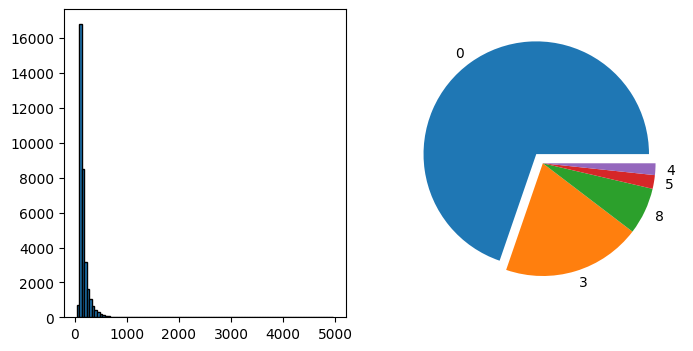

group_ix
0     10637
3      4953
5       455
4       432
20      230
Name: count, dtype: int64


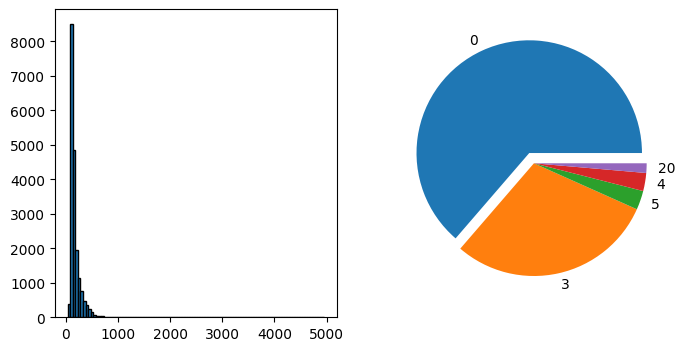

group_ix
0     2675
3     1607
4       99
5       52
38      48
Name: count, dtype: int64


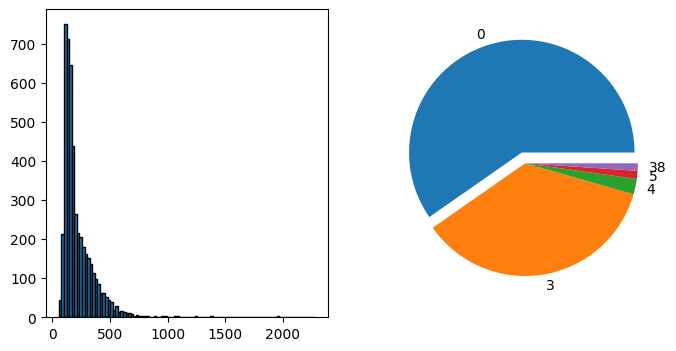

group_ix
0     391
3     365
4       9
39      9
38      7
Name: count, dtype: int64


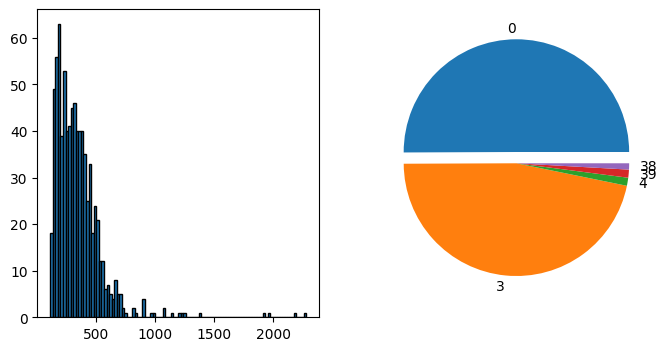

In [138]:
# display all pie charts from groups_r 
top_n = 5

for group in groups_r:
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].hist(group['stretch_seq'].apply(lambda x: len(x)), bins=100, edgecolor='black')
    ax[1].pie(group['group_ix'].value_counts()[:top_n], labels=group['group_ix'].value_counts().index[:top_n], 
            explode=[0.1] + [0 for _ in range(len(group['group_ix'].unique()) - 1)][:top_n-1])

    print(group['group_ix'].value_counts()[:top_n])
    plt.show()

In [139]:
group_dict

{'unassigned': 0,
 'group_42': 1,
 'group_38': 2,
 'group_0': 3,
 'group_1_0': 4,
 'group_1_1': 5,
 'group_58': 6,
 'group_2': 7,
 'group_1_2': 8,
 'group_102': 9,
 'group_21': 10,
 'group_31': 11,
 'group_3': 12,
 'group_84': 13,
 'group_14': 14,
 'group_5': 15,
 'group_85': 16,
 'group_25': 17,
 'group_39': 18,
 'group_19': 19,
 'group_4': 20,
 'group_59': 21,
 'group_73': 22,
 'group_15': 23,
 'group_8': 24,
 'group_86': 25,
 'group_66': 26,
 'group_34': 27,
 'group_1_3': 28,
 'group_113': 29,
 'group_10': 30,
 'group_30': 31,
 'group_51': 32,
 'group_114': 33,
 'group_17': 34,
 'group_27': 35,
 'group_11': 36,
 'group_23': 37,
 'group_12': 38,
 'group_6': 39,
 'group_77': 40,
 'group_7': 41,
 'group_28': 42,
 'group_94': 43,
 'group_1_4': 44,
 'group_78': 45,
 'group_35': 46,
 'group_55': 47,
 'group_103': 48,
 'group_67': 49,
 'group_60': 50,
 'group_68': 51,
 'group_26': 52,
 'group_43': 53,
 'group_24': 54,
 'group_74': 55,
 'group_63': 56,
 'group_87': 57,
 'group_104': 58,
 'g

In [140]:
# calculate the frequency of each amino acid in the hendecad repeat
group_4 = groups_r[-1]['stretch_seq']

aa_freq = {aa: 0 for aa in aa_dict.keys()}
total = 0

for seq in group_4:
    for aa in seq:
        aa_freq[aa] += 1
        total += 1

aa_freq = {aa: freq/total for aa, freq in aa_freq.items()}
aa_freq = dict(sorted(aa_freq.items(), key=lambda x: x[1], reverse=True))

aa_freq


{'a': 0.13707003172668447,
 'l': 0.12070479843696787,
 'v': 0.0975891304737493,
 'i': 0.09278173116564198,
 'g': 0.06899568015200129,
 's': 0.06712792844467548,
 't': 0.0589399343956694,
 'e': 0.051723458029360625,
 'd': 0.043040742798759614,
 'k': 0.04300130850167596,
 'q': 0.03937693810607826,
 'n': 0.035616340138737025,
 'p': 0.035282941081575224,
 'f': 0.025944182544946136,
 'm': 0.02591191812005951,
 'r': 0.02185377045654161,
 'y': 0.010174048647582857,
 'w': 0.009751026187958199,
 'h': 0.008826112674541576,
 'c': 0.006287977916793633,
 'u': 0.0,
 'x': 0.0}

### Sequence Properties

In [141]:
# compute amino acid frequency for all groups
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
repeat_numbers = [f'{i}R' for i in range(1, 11)]

total_aa_freq = {aa: 0 for aa in amino_acids}
total = 0

property_df = pd.DataFrame(columns=['group'] +  
                                    amino_acids +
                                    repeat_numbers +
                                    ['mean_length', 'std_length'])

groups = df['group_id'].unique()
for group in groups:
    group_df = df[df['group_id'] == group]
    
    aa_freq = {aa: 0 for aa in amino_acids}
    total = 0

    for seq in group_df['stretch_seq']:
        for aa in seq:
            aa_freq[aa.upper()] += 1
            total += 1

    aa_freq = {aa: freq/total for aa, freq in aa_freq.items()}
    # aa_freq = dict(sorted(aa_freq.items(), key=lambda x: x[1], reverse=True))
    
    mean_length = group_df['stretch_seq'].apply(lambda x: len(x)).mean()
    std_length = group_df['stretch_seq'].apply(lambda x: len(x)).std()

    # get number of repeats
    # TODO Doublecheck
    r_freq = {f'{i}R': 0 for i in range(1, 11)}

    for i in range(1, 11):
        pattern = r'[avilm].{2}[avilm].{3}[avilm].{3}' * i
        len_pattern = 11 * i

        res = []

        for j in range(len(group_df)):
            x, hits_ix = find_repeats(group_df.iloc[j]['stretch_seq'], pattern, len_pattern)

            if hits_ix == 0:
                res.append(x)
            else:    
                res.append(x)

        r_freq[f'{i}R'] = sum(res) / len(res)

    
    total_aa_freq = {aa: total_aa_freq[aa] + aa_freq[aa] for aa in amino_acids}
    
    property_df.loc[len(property_df)] = {'group': group, **aa_freq, **r_freq, 'mean_length': mean_length, 'std_length': std_length}

In [142]:
property_df.head()

,group,A,C,D,E,F,G,H,I,K,...,3R,4R,5R,6R,7R,8R,9R,10R,mean_length,std_length
0,unassigned,0.123723,0.008173,0.059755,0.092798,0.020785,0.066104,0.019502,0.032454,0.070289,...,0.455490,0.245947,0.146350,0.094233,0.060241,0.041464,0.029699,0.021690,153.270665,108.561357
1,group_42,0.121358,0.004806,0.042055,0.069691,0.014419,0.049564,0.026434,0.043557,0.029438,...,0.172414,0.068966,0.034483,0.000000,0.000000,0.000000,0.000000,0.000000,114.793103,24.520224
2,group_38,0.246801,0.000000,0.059519,0.085886,0.008918,0.077549,0.019387,0.013765,0.069213,...,0.781250,0.531250,0.281250,0.218750,0.187500,0.125000,0.031250,0.031250,161.187500,52.959776
3,group_0,0.105091,0.001750,0.040017,0.038803,0.047893,0.086149,0.004022,0.109629,0.055793,...,1.627243,0.745514,0.447445,0.281832,0.191762,0.130063,0.091608,0.070244,209.047855,112.751568
4,group_1_0,0.153089,0.001720,0.062651,0.059756,0.031894,0.082124,0.008660,0.060263,0.067587,...,0.967433,0.507663,0.241379,0.145594,0.082375,0.047893,0.032567,0.021073,154.844828,59.943871


<Axes: >

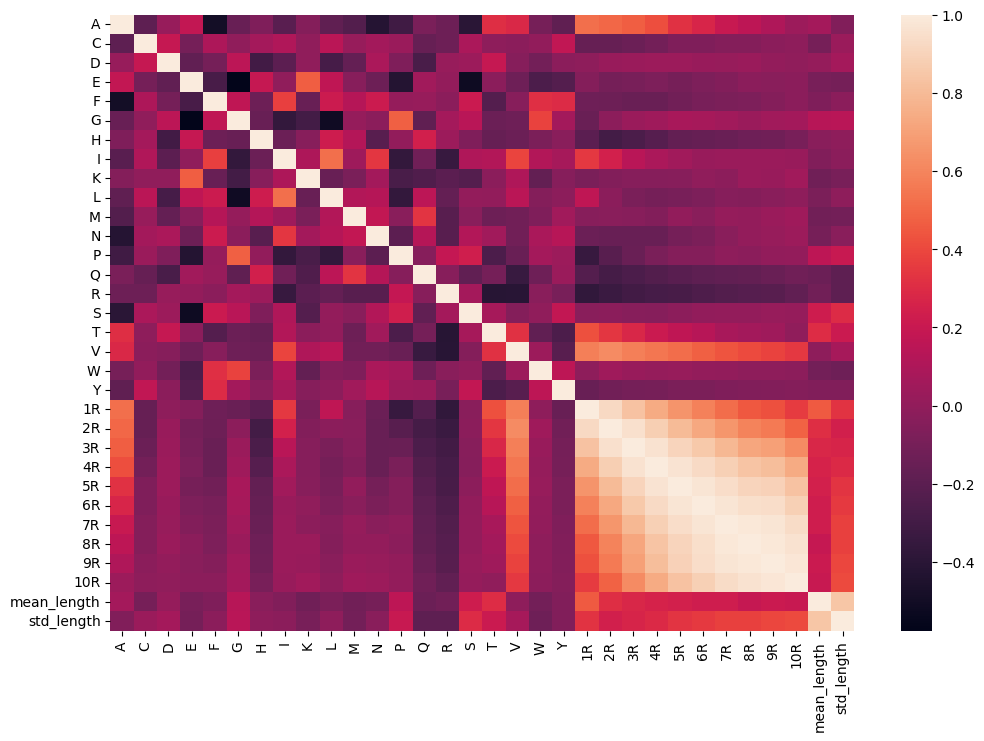

In [143]:
plt.figure(figsize=(12, 8))
sns.heatmap(property_df.drop(columns=['group']).corr())

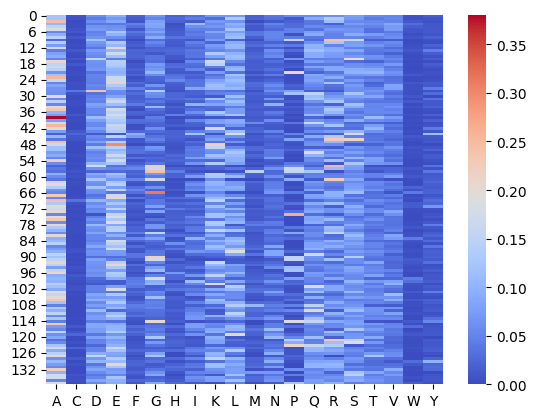

In [144]:
sns.heatmap(property_df[amino_acids], cmap='coolwarm')

plt.show()

<Axes: >

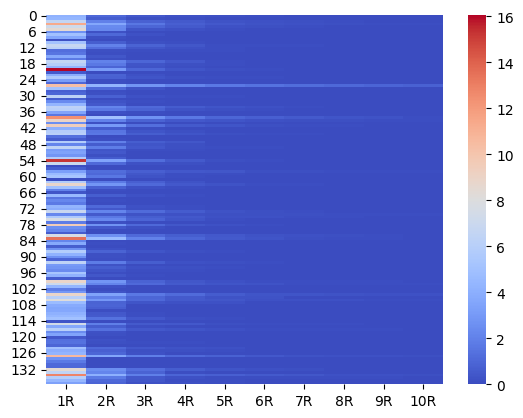

In [145]:
sns.heatmap(property_df[repeat_numbers], cmap='coolwarm')

### Sequence Motifs for xR

In [448]:
df[df['1R'] > 100]

,id,seq,stretch_ix,stretch_seq,avg_cc,group_id,group_ix,1R,2R,3R,...,7R_ratio,8R_ratio,9R_ratio,10R_ratio,25R_ratio,50R_ratio,75R_ratio,100R_ratio,150R_ratio,168R_ratio
334,XP_045614209.1,MTVKITATQVVRELAEKVIGSGSIQQGQPGDKVAIQISKDWRMAVV...,"[188, 856]",dideysceyddyrhqmnnrlrlqcyeywrdgynsrvtnaysfnvtn...,0.000136,unassigned,0,106,99,95,...,0.133446,0.129088,0.126316,0.123435,0.088832,0.058824,0.0,0.0,0.0,0.0
357,CAG9130562.1,MSVGAAAASAGAAAASAGAAAASVGVTAAGEAAASVGALAASMGVA...,"[50, 454]",aasvgapaagaaatsvgaaaadeaaasagapaaagaaapvapaatg...,0.000179,unassigned,0,123,63,32,...,0.021341,0.018927,0.016340,0.013559,0.000000,0.000000,0.0,0.0,0.0,0.0
538,EPQ16675.1,Madrglaqvsllaiadigldqvnplamadtglaqvsllaianigld...,"[103, 736]",aivnmglaqvsplamvnmgmaqvsllavantnlpltivnmalaqvs...,0.000146,unassigned,0,142,2,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
545,WP_094907754.1,MASAGDIVANLKLKVDNFNSGIENAGRKASEFGDNFQRTADSMKNV...,"[521, 1076]",ynaiktavtsgdftplfeavknlipmilsilmggiprlimmgaqli...,0.000171,group_0,3,140,70,37,...,0.008351,0.004274,0.002188,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
950,XP_017730169.1,MCPGPVVPTERAKalwaeegsgprslcldtlspsslsrlgpaaspw...,"[23, 1367]",rslcldtlspsslsrlgpaaspwlhflsivkeimskvpphheeeln...,0.000075,unassigned,0,159,39,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39664,XP_046548570.1,MYISIMDVSCRVRLHNRQGTLGIQQLSRSHVSLHSLCSSYIKFDLP...,"[212, 981]",slisvgltaligrrdidrrsflddlkkiaegilkevevvapkvies...,0.000117,unassigned,0,112,42,4,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
39692,WP_142087108.1,MAESYSVEAVMTADNSSMVAAFQEASNAASDMQAAIDNADMSGIAE...,"[482, 942]",tqtdiatdmisvfkgemefseaienmaemvfewaenlqemamlaie...,0.000154,group_0,3,120,61,43,...,0.039062,0.029491,0.019337,0.008547,0.000000,0.000000,0.0,0.0,0.0,0.0
40159,DAX80435.1,MAEEGLSLGTAWIDVVPSFKGLKKRIEEELGALGTSAVTEASESWG...,"[533, 930]",asggelttqiqtvisdmilnvskygmelvsnapqliasgaeavktl...,0.000181,group_0,3,108,48,17,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
40194,WP_025727707.1,MEENLRDMIVSINFDTDTSPVNDMTKAMREFSSSTDSTAREIVKSA...,"[902, 1306]",tgkviaqsivqlkpsfvqlgqafgelfsaiaqiiptllplfmqlfq...,0.000178,group_0,3,109,66,47,...,0.079268,0.072555,0.065359,0.057627,0.000000,0.000000,0.0,0.0,0.0,0.0


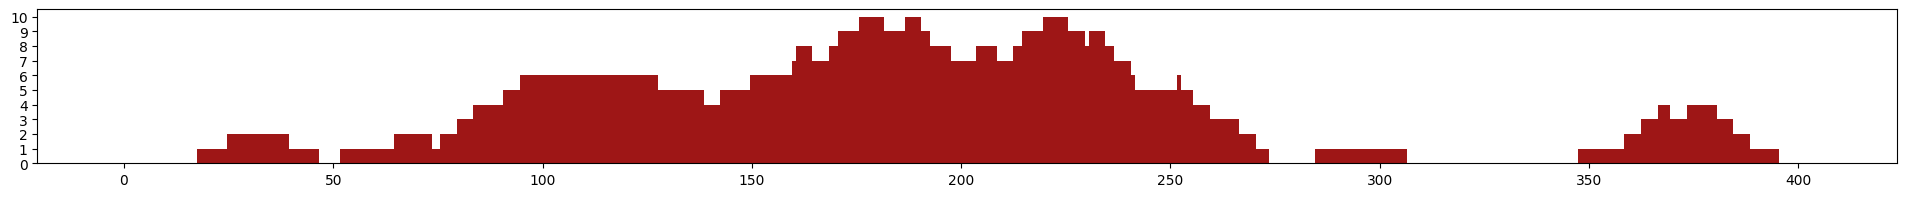

In [536]:
test = df.iloc[40194]
i = 2

len_test = len(test['stretch_seq'])

tmp = np.zeros(len_test)

fig, ax = plt.subplots(figsize=(24, 2))

for ix in test[f'{i}R_ix']:
    tmp[ix[0]:ix[1]] += 1

norm_tmp = tmp / np.max(tmp)

ax.bar(np.arange(len_test), tmp, color='#9e1616', width=1.0)
ax.set_yticks(np.arange(max(tmp)+1))


plt.show()


In [546]:
from Bio import motifs
from Bio.Seq import Seq
test = df.iloc[40194]
i = 2

len_test = len(test['stretch_seq'])

tmp = np.zeros(len_test)

repeat_seq = [Seq(test['stretch_seq'][ix[0]:ix[1]].upper()) for ix in test[f'{i}R_ix']]

repeat_seq

m = motifs.create(repeat_seq, alphabet=''.join(amino_acids))

motif = ''

M = []
for k, v in m.counts.items():
    M.append(v)

M = np.array(M)
M = M / M.sum(axis=0)

for i in range(M.shape[1]):
    max_aa_value = np.max(M[:, i])
    max_aa_ix = np.argmax(M[:, i])
    max_aa = list(m.counts.keys())[max_aa_ix]

    if max_aa_value > 0.3:
        motif += max_aa
    else:
        motif += '*'

motif

'V**I***I***V**II**VI**'